In [1]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import scipy
import seaborn as sns

from sklearn import datasets
from sklearn.linear_model import LinearRegression

In [2]:
import random

random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)

#### Задача со звездочкой 8: Экспоненциальный шум

Придумать и реализовать более умную оптимизацию линейной регрессии с экспоненциальным шумом, чем полным перебором по пространству весов. Правильный ответ должен быть **неотличим на глаз** от предсказаний модели.

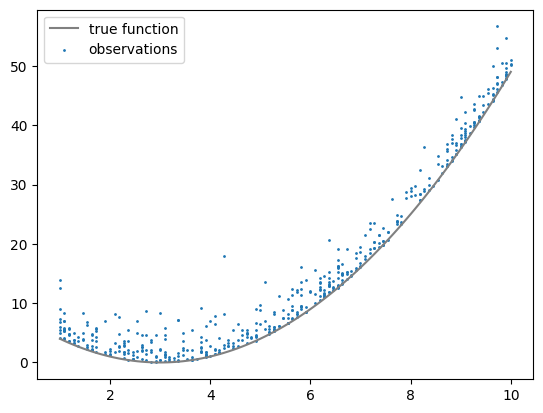

In [3]:
def f_true(x):
    return (x - 3) ** 2


x = np.linspace(1, 10, 100)
x_observed = np.random.choice(x, size=500, replace=True)
y_observed = f_true(x_observed) + np.random.exponential(2.0, len(x_observed))

plt.plot(x, f_true(x), c="grey", label="true function")
plt.scatter(x_observed, y_observed, s=1.0, label="observations")
plt.legend()
plt.show()

In [4]:
def get_design(x):
    return np.concatenate([x[:, None], x[:, None] ** 2], axis=1)

Введем регуляризацию в функцию потверь в виде экспоненты(т.к. она растет достаточно быстро, чтобы сильно вллиять на функци юпотерь даже при малейших изменениях аргумента) наибольшего расстояния от координаты $y$ точки данных до соответствующего предсказания.

In [5]:
def loss(X, y, W, alpha=10, _lambda=1):
    """
    PDF: lambda * exp (-lambda * x)

    :param X_data: observable features with (bias term at first coordinate)
                    expected shape: (n_samples, n_features + 1)
    :param y: observable target
                    expected shape: (n_samples)
    :param W: weight matrix (with bias term at first coordinate):
                    expexted_shape: (n_features + 1, )
    """
    preds = X @ W
    residuals = preds - y
    loss = _lambda * np.sqrt((np.square(residuals)).sum())
    if (residuals >= 0).any():
        return loss + alpha * np.exp(np.max(residuals))
    return loss.item()


def add_bias_to_features(X):
    X = np.concatenate([np.ones_like(X)[:, 0:1], X], axis=-1)
    return X


X = add_bias_to_features(get_design(x_observed))

print("Loss:", loss(X, y_observed, np.array([9, -6, 1])))

Loss: 64.94228444071744


Maximum number of function evaluations has been exceeded.
Loss: 67.59091685489057
Optimum: [ 9.43662486 -6.27527209  1.02441687  4.48748328]


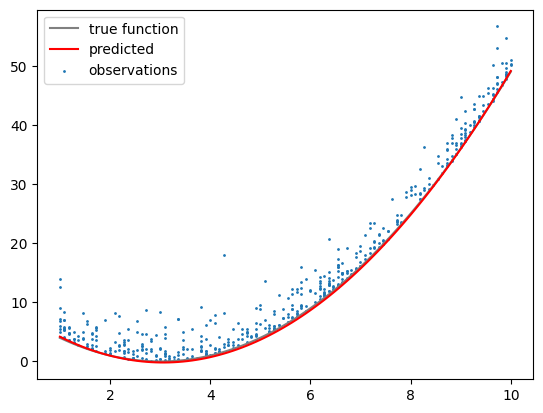

In [6]:
X = add_bias_to_features(get_design(x_observed))

bounds = [[-30, 30] for _ in range(X.shape[-1])] + [[1, 1000]]

W_optimal = scipy.optimize.minimize(
    lambda W: loss(X, y_observed, np.array(W[:-1]), alpha=W[-1]),
    x0=np.ones([X.shape[-1] + 1]),
    bounds=bounds,
    tol=1e-9,
    method="Nelder-Mead",
)

print(W_optimal.message)
a = W_optimal.x[-1]
W_optimal = W_optimal.x[:-1]

print("Loss:", loss(X, y_observed, W_optimal, alpha=a))
print("Optimum:", np.concatenate([W_optimal, [a]]))
plt.plot(x, f_true(x), c="grey", label="true function")
plt.plot(x, add_bias_to_features(get_design(x)) @ W_optimal, c="red", label="predicted")
plt.scatter(x_observed, y_observed, s=1.0, label="observations")
plt.legend()
plt.show()

Заметим, что если не вводить регуляризацию, построенная кривая регрессии очень близка по линейному и квадратичному коэффициенту к исходной кривой. Будет логично положить, что сдвинув ее вниз при помощи изменения коэффициента при константе можно будет очень хорошо приблизить исходную функцию. Для этого сдвинем кривую регрессии так, чтобы они проходила через наиболее отдаленную от нее снизу по $Oy$ точку данных.

In [7]:
def loss_noreg(X, y, W, _lambda=1):
    preds = X @ W
    residuals = preds - y
    loss = _lambda * np.sqrt((np.square(residuals)).sum())
    return loss.item()


X = add_bias_to_features(get_design(x_observed))

print("Loss:", loss(X, y_observed, np.array([9, -6, 1])))

Loss: 64.94228444071744


In [8]:
def get_design(x):
    return np.concatenate([x[:, None], x[:, None] ** 2], axis=1)

Optimization terminated successfully.
Loss: 46.286404085205575
Optimum: [11.26918279 -6.06792111  1.00369823]


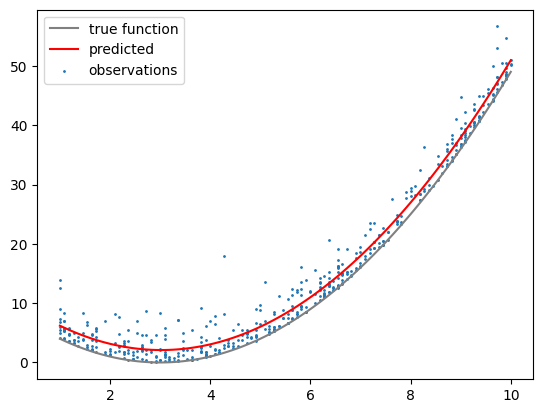

In [9]:
X = add_bias_to_features(get_design(x_observed))
W = np.ones(X.shape[-1]).T

bounds = [[-30, 30] for _ in W]

W_optimal = scipy.optimize.minimize(
    lambda W: loss_noreg(X, y_observed, np.array(W)),
    x0=W,
    bounds=bounds,
    tol=1e-9,
    method="Nelder-Mead",
)

print(W_optimal.message)
W_optimal = W_optimal.x

print("Loss:", loss_noreg(X, y_observed, W_optimal))
print("Optimum:", W_optimal)
plt.plot(x, f_true(x), c="grey", label="true function")
plt.plot(x, add_bias_to_features(get_design(x)) @ W_optimal, c="red", label="predicted")
plt.scatter(x_observed, y_observed, s=1.0, label="observations")
plt.legend()
plt.show()

In [10]:
delta = np.max(add_bias_to_features(get_design(x_observed)) @ W_optimal - y_observed)

In [11]:
delta

2.1200175976656155

In [12]:
W_optimal[0] = W_optimal[0] - delta

Equation: y = 1.0037x**2 + -6.0679x + 9.1492


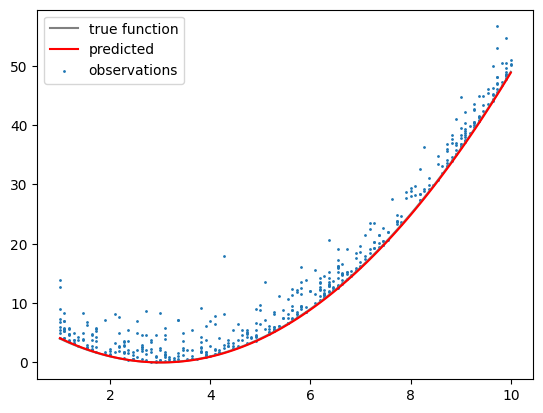

In [13]:
print(
    f"Equation: y = {W_optimal[2]:>0.4f}x**2 + {W_optimal[1]:>0.4f}x + {W_optimal[0]:>0.4f}"
)
plt.plot(x, f_true(x), c="grey", label="true function")
plt.plot(x, add_bias_to_features(get_design(x)) @ W_optimal, c="red", label="predicted")
plt.scatter(x_observed, y_observed, s=1.0, label="observations")
plt.legend()
plt.show()

#### Задача со звездочкой 9: Эллипс



Вы оказались одни в лесу, и вам очень надо восстановить уравнение эллипса по данным. Как на зло, все что у вас есть - это `sklearn.linear_model.LinearRegression`.



**1 балл.** К счастью, вы знаете что эллипс не абы какой, а с осями, параллельными осям координат. 



**1 балл.** А теперь не знаете. (WARNING: я не уверен в том, что это возможно c `LinearRegression`, но OLS может)

In [14]:
# Правильный ответ

CENTER_X = -5.0
CENTER_Y = 2.0
SCALE_X = 2.0
SCALE_Y = 3.0
ANGLE = np.pi / 6

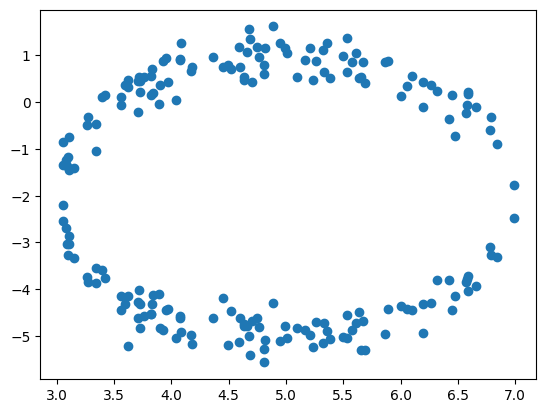

In [15]:
# Генерируем данные

x = np.random.rand(100) * 2 - 1
y_pos = np.sqrt(1 - x**2) + np.random.normal(0, 0.1, 100)
y_neg = -np.sqrt(1 - x**2) + np.random.normal(0, 0.1, 100)
y = np.hstack([y_pos, y_neg])
x = x * SCALE_X - CENTER_X
y = y * SCALE_Y - CENTER_Y
x = np.hstack([x, x])
data = np.stack([x, y], axis=1)
plt.scatter(data[:, 0], data[:, 1])
plt.show()

Уравнение эллипса с осями, параллельными осям координат, имеет следующий вид:

$$
\frac{(x-x_0)^2}{a^2}+\frac{(y-y_0)^2}{b^2}=1,
$$

где $a,\, b$ $-$ размеры полуосей данного эллипса, а $x_0$ и $y_0$ это координаты его центра. Заметим, что после некоторых преобразований это уравнение можно преобразовать к линейному относительно $x^2$ и $y^2$:

$$
(y-y_0)^2 = b^2 - \frac{b^2}{a^2}(x-x_0)^2.
$$

Найдем координаты центра эллипса как мат. ожидания координат точек данных по $Ox$ и $Oy$ и перенесем начало координат в центр эллипса.

Center coordinates: (4.7584, -2.0169)


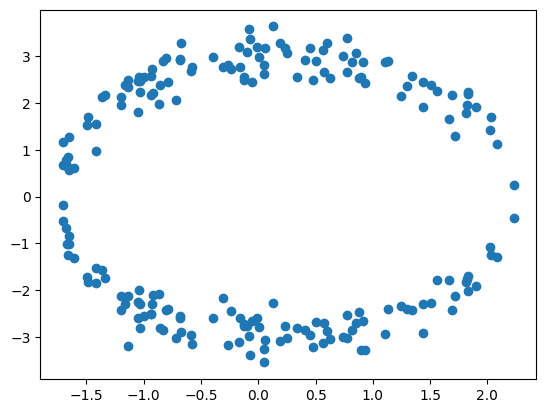

In [16]:
x_0 = np.mean(x)
y_0 = np.mean(y)
print(f"Center coordinates: ({x_0:>0.4f}, {y_0:>0.4f})")

x_centered = x - x_0
y_centered = y - y_0
data = np.stack([x_centered, y_centered], axis=1)
plt.scatter(data[:, 0], data[:, 1])
plt.show()

/tmp/ipykernel_17/422180939.py:5: RuntimeWarning: invalid value encountered in sqrt
  plt.scatter(x_centered + x_0, np.sqrt(y_pred) + y_0, c="red", s=1.0)
/tmp/ipykernel_17/422180939.py:6: RuntimeWarning: invalid value encountered in sqrt
  plt.scatter(x_centered + x_0, -np.sqrt(y_pred) + y_0, c="red", s=1.0)


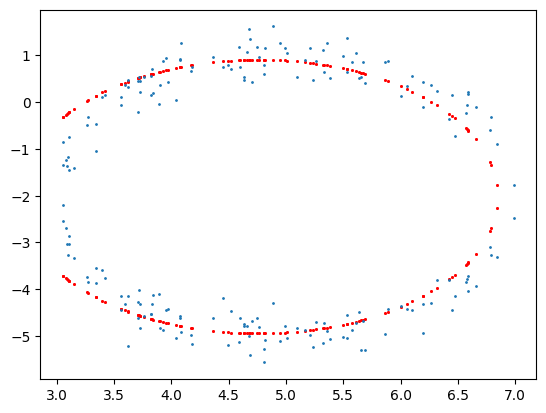

In [17]:
regr = LinearRegression()
regr.fit(x_centered[:, None] ** 2, y_centered[:, None] ** 2)
y_pred = regr.predict(x_centered[:, None] ** 2)

plt.scatter(x_centered + x_0, np.sqrt(y_pred) + y_0, c="red", s=1.0)
plt.scatter(x_centered + x_0, -np.sqrt(y_pred) + y_0, c="red", s=1.0)
plt.scatter(x, y, s=1.0)
plt.show()

Таким образом, полуоси имеют следуюющий вид:

In [18]:
k = regr.coef_[0, 0]
b = regr.intercept_[0]
print(f"Regression semiaxes: a = {np.sqrt(1/(-k)*b):>0.4f}, b = {np.sqrt(b):>0.4f}")
print(f"True semiaxes: a = {SCALE_X}, b = {SCALE_Y}")

Regression semiaxes: a = 2.0927, b = 2.9281
True semiaxes: a = 2.0, b = 3.0
